# Plot leadtime network comparisons

Compare prediction skill for several different networks

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [62]:
# Paths
datpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/" # path to the data
outpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/Figures/" # output directory

# Experiment parameters
leadtime   = 25  # Lead time in months (include lag 0)
num_epochs = 10   # Number of Epochs tested for
nmembers   = 40   # Total number of ensemble members used 
netname    = 'CNN2' # Network Type [CNN1,CNN2,FNN,LR]
netlong    = "2-Layer CNN (CNN2)" # Network Long Name
season     = 'Ann'
resolution = '2deg'
indexregion = 'NAT'

# Save Figures? (Set to True to save to outpath)
savefigures = True

# Set variable names
varnames = ["SST","SSS","PSL","ALL"]
netnames = ["MLR","FNN2","CNN2"]

slongname = ["Multi-linear Regression",
             "2-Layer Fully-Connected Neural Network",
             "2-layer Convolutional Neural Network"]
slines   = ["solid","solid","solid"]
scolors  = ["gold","coral","royalblue"]

In [68]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index


def load_experiment(varnames,datpath,season,resolution,indexregion,netname,num_epochs,nmembers,leadtime):
    """
    
    
    inputs:
        1. varnames : [TUPLE] of variables that will be loaded from ['SST','SSS','PSL','ALL']
        2. datpath  : [STR] path to the data location
        3. season   : [STR] 3-letter identifier for the season
        4. resolution : [STR] Resolution of dataset ['2deg' or 'full']
        5. indexregion : [STR] AMV index region that was predicted ["NAT","SPG","STG","TRO"]
        6. netname : [STR] name of the network
        7. num_epochs: [INT] number of training epcohs
        8. nmembers : [INT] number of ensemble members used
        9. leadtime : [INT] maximum leadtime
        
    output:
        1. expname : [STR] experiment identifier
        2. train_loss : [ARRAY] [variable x epoch x leadtime]
        3. test_loss : [ARRAY] [variable x epoch x leadtime]
        4. test_corr : [ARRAY] [variable x leadtime]
        5. train_corr : [ARRAY] [variable x leadtime]
        
    """
    # Set experiment name
    expname = "%s%s_%s_%s_nepoch%02i_nens%02i_lead%02i" % (season,resolution,indexregion,netname,num_epochs,nmembers,leadtime-1)
    print("Loading experiment: %s"%expname)
    
    # Preallocate
    nvars = len(varnames)
    train_loss = np.zeros((nvars,num_epochs,leadtime)) # [variable x epoch x leadtime]
    test_loss  = np.zeros(train_loss.shape) # [variable x epoch x leadtime]
    test_corr    = np.zeros((nvars,leadtime)) # [variable x leadtime]
    train_corr   = np.zeros(test_corr.shape) # [variable x leadtime]
    
    for v,vname in enumerate(varnames):
        vname = varnames[v]

        # Load NPZ file
        results = np.load("%sleadtime_testing_%s_%s.npz"%(datpath,vname,expname))

        # Get correlation for train and test (note, need to rename arrays in future...)
        train_loss[v,:,:] = results['train_loss'].copy() # [n_epochs,lead]
        test_loss[v,:,:] = results['test_loss'].copy()  # [n_epochs,lead] 
        test_corr[v,:] = results['test_corr'].copy()  # [lead,]
        train_corr[v,:] = results['train_corr'].copy() # [lead,]
        
        print("Loaded %s"%vname)
        
    return expname,train_loss,test_loss,test_corr,train_corr

def plot_corrleadtime(invar,nvars,sst_auto,netname,title,nmembers=40,ax=None):
    """
    Make a line plot comparing predictors for a given NN
    """
    
    if ax is None:
        ax.gca()
    for ien in range(nmembers): # Plot CESM Reults
        ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
    ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
    ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
    if nvars==4:
        for v in range(nvars): # Plot CNN Results
            ax.plot(invar[v,:],label=netname + " " + varnames[v])
    else:
        ax.plot(invar[nvars,:],label=netname + " " + varnames[nvars])
    ax.legend(ncol=2,fontsize=8)  
    ax.set_title(title)
    ax.set_ylabel("Correlation")
    ax.set_ylim([-.1,1])
    ax.set_xlabel("Prediction Lead Time (years)")
    ax.set_yticks(np.arange(-1,1.2,.2))
    return ax

In [25]:
%%time
# Calculate AMV Index Autocorrleation

# Load in data
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_Ann.npy' % (resolution)).astype(np.float32)
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))

# Calculate Autocorrelation
tstep = 86
lags  = 25

sst_ensemble = calc_AMV_index('NAT',sst_normed[:,:,:,:],lat,lon)
sst_lagged_corr = np.zeros((nmembers,lags))

for lead in range(lags):
    sst_lead = sst_ensemble[:,lead:]
    sst_lag = sst_ensemble[:,0:tstep-lead]
    #sss_lag = sss_ensemble[:,0:tstep-lead]

    for ien in range(nmembers):
        sst_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sst_lag[ien,:] )[0,1]    
sst_auto = sst_lagged_corr.copy()



CPU times: user 132 ms, sys: 7.35 ms, total: 140 ms
Wall time: 139 ms


In [26]:
# Now load in results from each experiment
test_losses = []
train_losses = []
test_corrs = []
train_corrs = []
expids = []
for netname in netnames:
    
    ld = load_experiment(varnames,datpath,season,resolution,indexregion,netname,num_epochs,nmembers,leadtime)
    
    expids.append(ld[0])
    train_losses.append(ld[1])
    test_losses.append(ld[2])
    test_corrs.append(ld[3])
    train_corrs.append(ld[4])
    
    print("Finished loading data for netname %s"%netnames)
    

Loading experiment: Ann2deg_NAT_MLR_nepoch10_nens40_lead24
Loaded SST
Loaded SSS
Loaded PSL
Loaded ALL
Finished loading data for netname ['MLR', 'FNN2', 'CNN2']
Loading experiment: Ann2deg_NAT_FNN2_nepoch10_nens40_lead24
Loaded SST
Loaded SSS
Loaded PSL
Loaded ALL
Finished loading data for netname ['MLR', 'FNN2', 'CNN2']
Loading experiment: Ann2deg_NAT_CNN2_nepoch10_nens40_lead24
Loaded SST
Loaded SSS
Loaded PSL
Loaded ALL
Finished loading data for netname ['MLR', 'FNN2', 'CNN2']


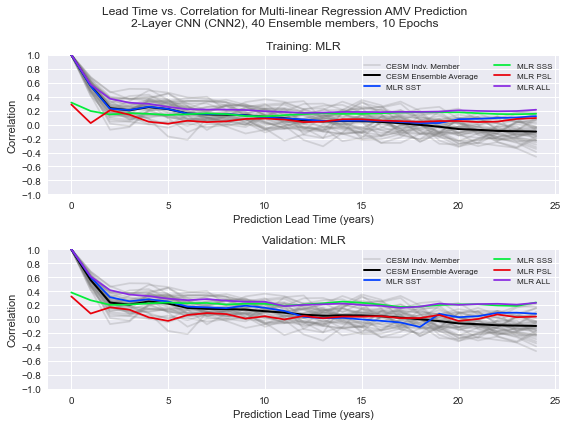

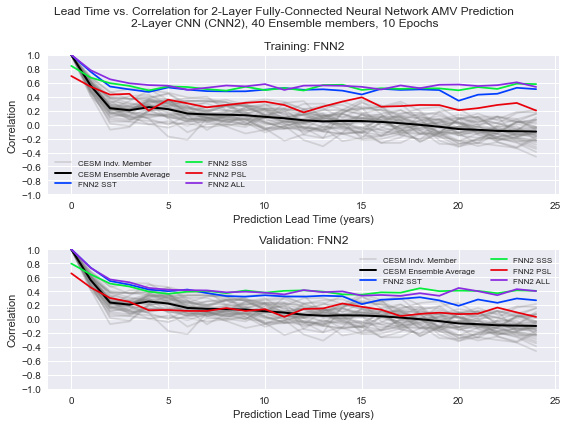

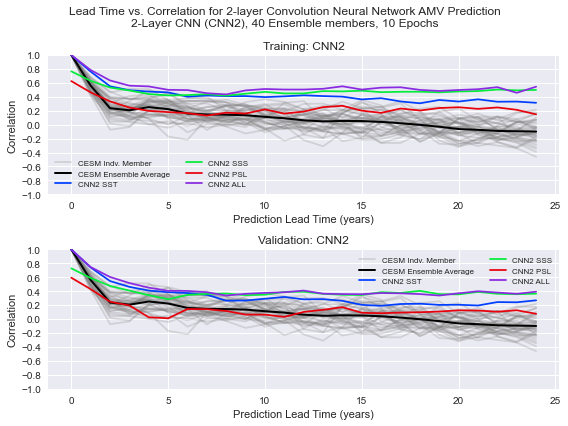

In [27]:
# Compare predictability separately in each region to the CESM average
nvars = 4 # number of predictors to plot

for r,netname in enumerate(netnames):
    fig,axs = plt.subplots(2,1,sharey=True,figsize=(8,6))
    plt.style.use('seaborn')
    plt.style.use('seaborn-bright')
    
    ax = axs[0]
    ax = plot_corrleadtime(train_corrs[r],nvars,sst_auto,netname,"Training: %s"%(netname),ax=ax)
    
    ax = axs[1]
    ax = plot_corrleadtime(test_corrs[r],nvars,sst_auto,netname,"Validation: %s"%(netname),ax=ax)
    
    # title and layout formatting
    plt.suptitle("Lead Time vs. Correlation for %s AMV Prediction" % (slongname[r]) + "\n" + 
                 "%s, %s Ensemble members, %s Epochs"%(netlong,nmembers,num_epochs))
    plt.tight_layout()
    
    plt.savefig("%sCorrelation_vs_Leadtime_CESM_NAT_%s.png"%(outpath,netname),dpi=200)
    

In [28]:
# # Plot by predictor, comparing for different regions


# #plotmode ='tes' # or "train"

# for v,vname in enumerate(varnames):
    
#     # Plot for validation
#     fig,ax = plt.subplots(1,1,sharey=True,figsize=(8,6))
#     plt.style.use('seaborn')
#     plt.style.use('seaborn-bright')
    
#     for r,region in enumerate(regions):
#         invar = test_corrs[r]
#         ax.plot(invar[v,:],color=scolors[r],label=netname + " " + slongname[r]  + " "+ varnames[v])
    
#     ax.legend()
#     ax.set_title("Comparing Regional AMV Predictability in CESM using %s as Predictor"%vname)
#     ax.set_ylabel("Correlation")
#     ax.set_ylim([-.1,1])
#     ax.set_yticks(np.arange(-.1,1.1,.1))
#     ax.set_xlabel("Prediction Lead Time (years)")
#     plt.savefig("%sCESM1_%s_Persistence_%s.png"%(outpath,netname,vname))
# #     # First plot the ensemble average
# #     sst_auto = amvindices[r]
# #      for ien in range(nmembers): # Plot CESM Reults
# #         ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
        
# #     ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
# #     ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
    
    

    
# #     # Plot based on mode
# #     if plotmode == 'test':
# #         ax = plot_corrleadtime(test_corrs[r],v,amvindices[r],netname,"Testing: %s"%(netname),ax=ax)
# #     elif plotmore == 'train:'
# #         ax = plot_corrleadtime(train_corrs[r],v,amvindices[r],netname,"Training: %s"%(netname),ax=ax)
    
# #     plt.suptitle("Lead Time vs. Correlation for %s AMV Prediction" % (slongname[r]) + "\n" + 
# #                  "%s, %s Ensemble members, %s Epochs"%(netlong,nmembers,num_epochs))
# #     plt.tight_layout()
    
# #     plt.savefig("%sCorrelation_vs_Leadtime_CESM_%s.png"%(outpath,region),dpi=200)
    
    
    
    
    

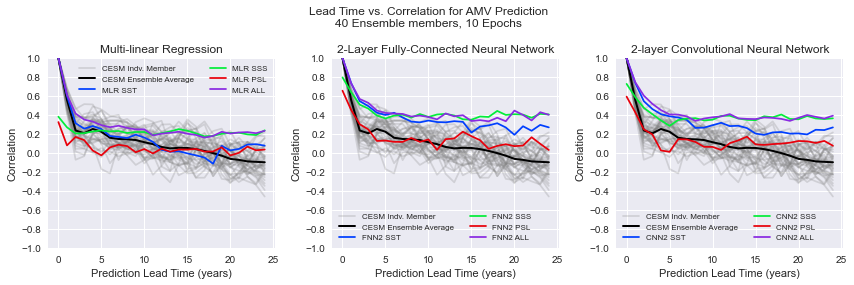

In [63]:
# 3-way plot for each region, testing only
nvars = 4 # number of predictors to plot


fig,axs = plt.subplots(1,3,figsize=(12,4))
plt.style.use('seaborn')
plt.style.use('seaborn-bright')

r  = 0
ax = axs[r]
ax = plot_corrleadtime(test_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)

r  = 1
ax = axs[r]
ax = plot_corrleadtime(test_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)

r  = 2
ax = axs[r]
ax = plot_corrleadtime(test_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)



    
# title and layout formatting
plt.suptitle("Lead Time vs. Correlation for AMV Prediction" + "\n" + 
             "%s Ensemble members, %s Epochs"%(nmembers,num_epochs))
plt.tight_layout()
plt.savefig("%sCorrelation_vs_Leadtime_CESM_%s_allmodels.png"%(outpath,netname),dpi=200)
    

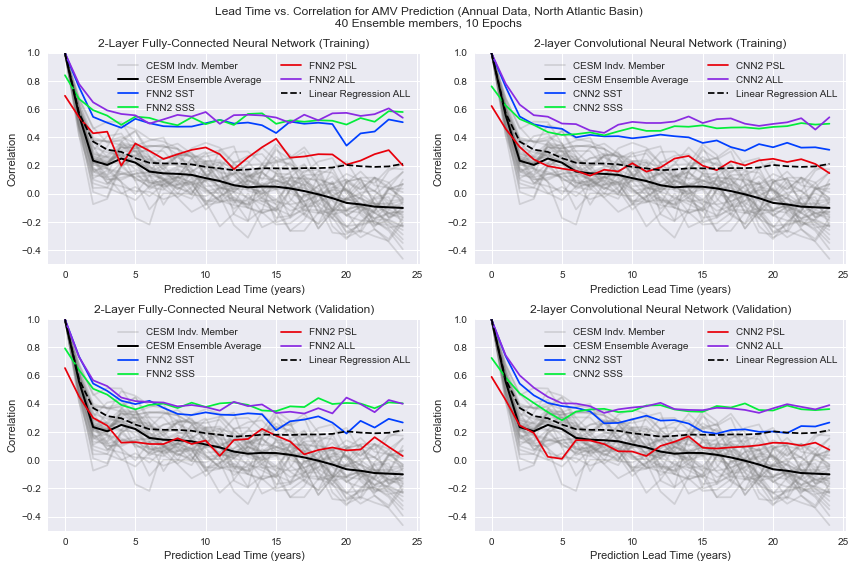

In [75]:
# 2x2-way plot for each region, testing only
nvars = 4 # number of predictors to plot
ylm = [-.5,1]

fig,axs = plt.subplots(2,2,figsize=(12,8))
plt.style.use('seaborn')
plt.style.use('seaborn-bright')

r  = 1
ax = axs[0,0]
ax = plot_corrleadtime(train_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)
ax.plot(train_corrs[0][-1,:],color='k',ls='dashed',label='Linear Regression ALL')
ax.set_ylim(ylm)
ax.set_title(slongname[r]+ " (Training)")
ax.legend()
ax.legend(ncol=2)

r  = 1
ax = axs[1,0]
ax = plot_corrleadtime(test_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)
ax.plot(train_corrs[0][-1,:],color='k',ls='dashed',label='Linear Regression ALL')
ax.set_ylim(ylm)
ax.set_title(slongname[r]+ " (Validation)")
ax.legend(ncol=2)

r  = 2
ax = axs[0,1]
ax = plot_corrleadtime(train_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)
ax.plot(train_corrs[0][-1,:],color='k',ls='dashed',label='Linear Regression ALL')
ax.set_ylim(ylm)
ax.set_title(slongname[r]+ " (Training)")
ax.legend(ncol=2)

r  = 2
ax = axs[1,1]
ax = plot_corrleadtime(test_corrs[r],nvars,sst_auto,netnames[r],"%s"%(slongname[r]),ax=ax)
ax.plot(train_corrs[0][-1,:],color='k',ls='dashed',label='Linear Regression ALL')
ax.set_ylim(ylm)
ax.set_title(slongname[r]+ " (Validation)")
ax.legend(ncol=2)

# title and layout formatting
plt.suptitle("Lead Time vs. Correlation for AMV Prediction (Annual Data, North Atlantic Basin)" + "\n" + 
             "%s Ensemble members, %s Epochs"%(nmembers,num_epochs))
plt.tight_layout()
plt.savefig("%sCorrelation_vs_Leadtime_CESM_%s_FnnVSCnn.png"%(outpath,netname),dpi=200)
    

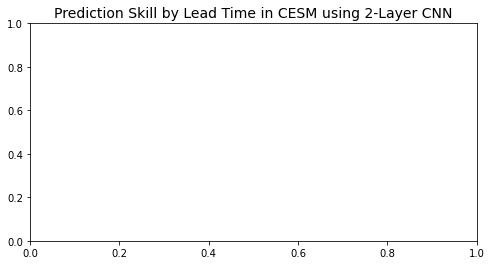

In [8]:
# Print the font to save

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.set_title("Prediction Skill by Lead Time in CESM using 2-Layer CNN",fontsize=14)
plt.savefig(outpath+"title.png",dpi=200)

In [67]:
netnames[r] + " (Training)"

'CNN2 (Training)'

In [77]:
for i in range(len(test_losses)):
    print(np.nanmax(test_losses[i]))

0.12382227927446365
0.12512883613817394
0.12293392093852162
